# Statistical Methods in Image Processing EE-048954
## Homework 2: Langevin Dynamics and Energy-Based Models
### Due Date: <span style="color:red">May 31, 2022</span>

###  Submission Guidelines

* Submission only in **pairs** on the course website (Moodle).
* Working environment:
    * We encourage you to work in `Jupyter Notebook` online using <a href="https://colab.research.google.com/">Google Colab</a> as it does not require any installation.
* You should submit two **separated** files:
    * A `.ipynb` file, with the name: `ee048954_hw2_id1_id2.ipynb` which contains your code implementations.
    * A `.pdf` file, with the name: `ee048954_hw2_id1_id2.pdf` which is your report containing plots, answers, and discussions.
    * **No handwritten submissions** and no other file-types (`.docx`, `.html`, ...) will be accepted.

### Mounting your drive for saving/loading stuff

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
# % cd /content/drive/MyDrive/temp/

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

### Importing relevant libraries for Part I

In [3]:
## Standard libraries
import os
import math
import time
import numpy as np
import random
import copy

## Scikit-learn built-in dataset generator
from sklearn.datasets import make_blobs

## Progress bar
import tqdm

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
plt.style.use('ggplot')

## Part I: Toy 2D Dataset (10 points)

In this homework we will look into stochastic sampling techniques that could be used to sample from energy-based models of images. But, to kick things off, we will first start with the simple toy 2D dataset comprised of 5 rotated and equally-spaced Gaussian Mixture distribution we are familiar with from HW1 with slight adjustments: 

<center width="100%"><img src="https://drive.google.com/uc?id=1DUVGzms8W_u7HrVyFb1QSxeszY9cs8Nr" width="800px"></center>

More formally, the probability density distribution considered is given by:

  $$p(x;\sigma,\{\mu_i\}) = \frac{1}{M} \sum_{m=1}^{M} \frac{1}{2\pi\sigma^2} \exp\left\{-\frac{1}{2\sigma^2}||x-\mu_i||^2\right\} ,$$
   with $M = 5$, $\sigma^2 = 0.1$, 
   
   and $\{\mu_m\} = 0.7 \cdot \{(1,0)^T , (\cos(\frac{2\pi}{5}),\sin(\frac{2\pi}{5}))^T , (\cos(\frac{4\pi}{5}),\sin(\frac{4\pi}{5}))^T , (\cos(\frac{6\pi}{5}),\sin(\frac{6\pi}{5}))^T , (\cos(\frac{8\pi}{5}),\sin(\frac{8\pi}{5}))^T\}$.
  
<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 1</span>**. Write down the analytical gradient of $\log p(x)$ with respect to $x$. i.e. $\nabla_x \log p(x)$.

#### $\color{#007FFF}{\textbf{Answer:}}$

$$ \nabla_{x}\log p(x)=	\frac{1}{p(x)}\nabla_{x}p(x)
=	\frac{1}{\frac{1}{M}\sum_{m=1}^{M}\frac{1}{2\pi\sigma^{2}}e^{-\frac{1}{2\sigma^{2}}\|x-\mu_{i}\|^{2}}}\cdot\frac{1}{M}\sum_{m=1}^{M}\frac{1}{2\pi\sigma^{2}}e^{-\frac{1}{2\sigma^{2}}\|x-\mu_{i}\|^{2}}\cdot\left(-\frac{1}{2\sigma^{2}}2(x-\mu_{i})\right)
=	\frac{1}{\sigma^{2}}\frac{\sum_{m=1}^{M}e^{-\frac{1}{2\sigma^{2}}\|x-\mu_{i}\|^{2}}(\mu_{i}-x)}{\sum_{m=1}^{M}e^{-\frac{1}{2\sigma^{2}}\|x-\mu_{i}\|^{2}}} $$

While this distribution can be sampeld trivially using standard techniques, here we will sample from it using Langevin Dynamics. 

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 2</span>**. Implement Langevin Dynamics for sampling from $p(x)$:
* Initialize 1000 random 2D points $x$ i.i.d distributed according to $U[-3.0,3.0]$.

* Update the points according to the Langevin Dynamics update step:
$$x^{k+1} = x^k + \varepsilon \nabla \log p(x^k) + \sqrt{2\varepsilon}N^k.$$
Use $\sqrt{2\varepsilon}=\frac{10}{256}$ and $N \sim \mathcal{N}(0,I)$.

* Repeat the previous step for $K=5000$ iterations.

In [4]:
num_samples, seed, = 1000 , 0
np.random.seed(seed)
angles = np.linspace(0, 2 * np.pi, 5, endpoint=False)
centers = np.stack([0.7 * np.array([np.cos(angle), np.sin(angle)]) for angle in angles])
real_samples = make_blobs(num_samples, centers=centers, cluster_std=np.sqrt(.1), random_state=seed, shuffle=True)[0]

In [5]:
def log_gradient_p_blob(x, sigma_2=0.01, mu=centers):
    N = len(mu)
    denominator = 0
    for i in range(N):
        denominator += np.exp((-1/(2*sigma_2)) * np.linalg.norm(x-mu[i], axis=1) ** 2 )
    denominator = np.reshape(denominator, (denominator.shape[0],1))
    
    nominator = 0
    for i in range(N):  
        s = (np.exp((-1/(2*sigma_2)) * np.linalg.norm(x-mu[i], axis=1) ** 2 ))
        d = (mu[i] - x).transpose()
        nominator +=  s * d 
    
    return (1/sigma_2) * nominator.transpose() / denominator

In [6]:
def langevin_dynamics(N=5000, S=1000, sigma_2=0.1, factored_epsilon=10/256):
    x = np.random.uniform(low=-3, high=3, size=(S,2))
    for i in tqdm.tqdm(range(N)):
        x = langevin_step(x_n=x, sigma_2=sigma_2, factored_epsilon=factored_epsilon)
        
    return x

In [7]:
def langevin_step(x_n, factored_epsilon=10/256, log_gradient_p = log_gradient_p_blob, sigma_2 = 0.1):
    noise = np.random.randn(x_n.shape[0], x_n.shape[1])
    epsilon = (factored_epsilon ** 2) / 2
    return x_n + epsilon * log_gradient_p(x_n, sigma_2=sigma_2) + factored_epsilon * noise

In [8]:
def plot_scatter(samples, title, group=None):
    if group is not None:
        plt.scatter(samples[:, 0], samples[:, 1], c=group)
    else:
        plt.scatter(samples[:, 0], samples[:, 1])
    plt.title(title)
    plt.show()    

In [9]:
def sub_plot_scatter(samples_list, titles_list, width, figsize=(15,5)):
    N = len(samples_list)
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    rows = int(N/width)
    
    for i in range(rows):
        for j in range(width):
            idx = rows * i + j
            if rows > 1:
                axes[i,j] = plt.scatter(samples_list[idx][:, 0], samples_list[idx][:, 1])
                axes[i,j].set_title(titles_list[idx])
            else:
                axes[idx].set_title(titles_list[idx])
                axes[idx].scatter(samples_list[idx][:, 0], samples_list[idx][:, 1])

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 3</span>**. Draw $N = 1000$ samples ${x_i}$ from $p(x)$ using the provided code lines below and compare them visually to the samples drawn using Langevin Dynamics. Present both sample types and discuss the results.

In [10]:
x = langevin_dynamics(N=5_000, S=1_000)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 884.51it/s]


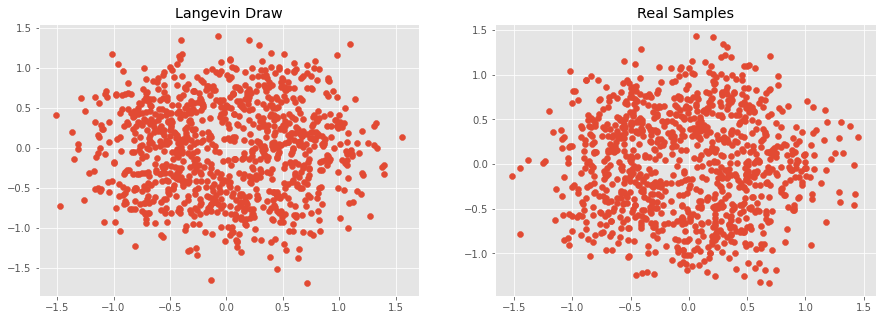

In [11]:
sub_plot_scatter(samples_list=[x, real_samples], titles_list=['Langevin Draw', 'Real Samples'], width=2)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 960.23it/s]


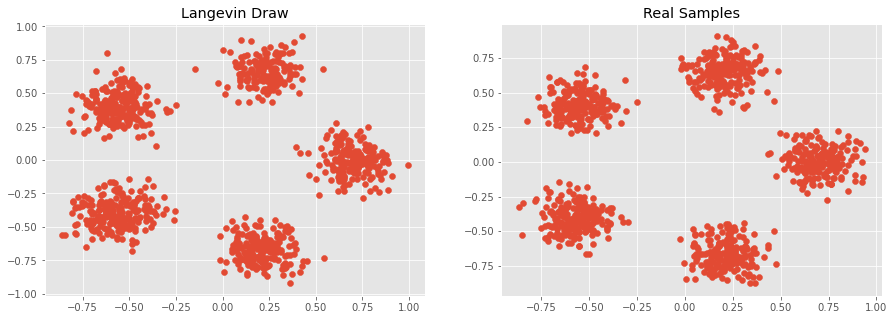

In [12]:
x_2 = langevin_dynamics(N=5_000, S=1_000, sigma_2=0.01)
real_samples_2 = make_blobs(num_samples, centers=centers, cluster_std=np.sqrt(.01), random_state=seed, shuffle=True)[0]
sub_plot_scatter(samples_list=[x_2, real_samples_2], titles_list=['Langevin Draw', 'Real Samples'], width=2)

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 4</span>**. Repeat Tasks 2 and 3, this time with $\sqrt{2\varepsilon}=\left\{\frac{1}{256}, \frac{200}{256}\right\}$. Compare the results to Task 3, and explain the effect of $\varepsilon$ on the resulting samples. Tip: To have a clear visual examination of the phenomenon, plot the path a sampled point goes through throughout the dynamics for different values of $\varepsilon$.

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 962.81it/s]


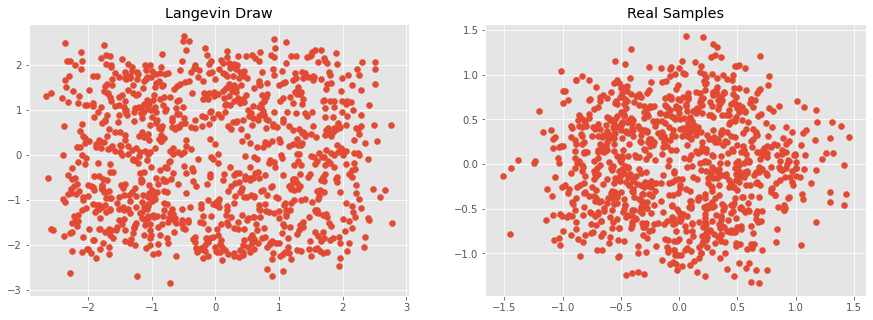

In [13]:
x = langevin_dynamics(N=5_000, S=1_000, factored_epsilon=1/256)
sub_plot_scatter(samples_list=[x, real_samples], titles_list=['Langevin Draw', 'Real Samples'], width=2)

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]C:\Users\neria\anaconda3\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 974.23it/s]


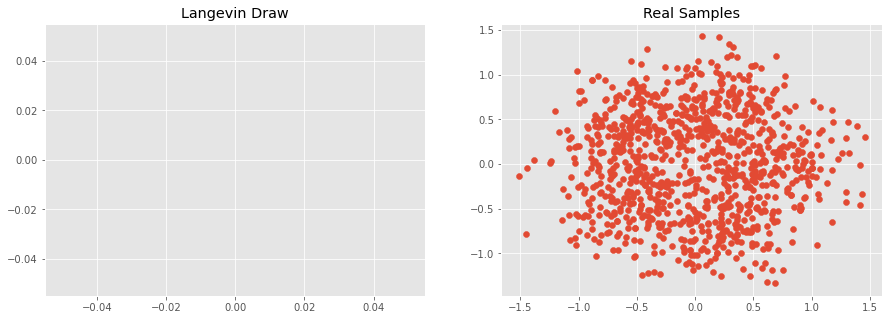

In [14]:
x = langevin_dynamics(N=5_000, S=1_000, factored_epsilon=200/256)
sub_plot_scatter(samples_list=[x, real_samples], titles_list=['Langevin Draw', 'Real Samples'], width=2)

## $\color{#007FFF}{\textbf{Discussion:}}$
For $\sqrt{2\epsilon}=\frac{10}{256}$  we also plot the blobs with lower sigma to see in a more distinct way the similarity of the draws. 
For $\sqrt{2\epsilon}=\frac{10}{256}$ the results match almost perfectly. <br>
For $\sqrt{2\epsilon}=\frac{1}{256}$ the generated dots seem to be more dispersed than the original, probably because the process didn't converge fast enough. <br>
For $\sqrt{2\epsilon}=\frac{100}{256}$ the process diverges due to step size that are too big.

### Importing additional relevant libraries for Parts II-IV

In [15]:
## Useful for creating GIFs
import imageio

## PyTorch
import torch
import torchvision

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# device to be used for Parts II-IV is preferably a GPU
# try to change the runtime type to GPU if you can in Google Colab
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Using device", device)

Using device cuda:0


## Part II: Langevin Dynamics (30 points) 

### General Introduction

In the remainder of this exercise we will focus on sampling from an Energy Based Model (EBM) that was trained to fit the distribution $p(x)$ of the [MNIST digits dataset](http://yann.lecun.com/exdb/mnist/) (no need to download the dataset). The EBM is given in the form of a Convolutional Neural Network (CNN), and defined by
$$ p_\theta(x) = \frac{1}{Z(\theta)}e^{-E_\theta(x)}.$$
Specifically, the model gets an image $x$ and returns $E_\theta(x)$, where $\theta$ are the trained model parameters. We will use this model in order to sample new digits from the MNIST distribution. In order to do so, we will use MCMC with Langevin Dynamics.

### Model Architecture

The provided class below `ResNet` implements the neural network approximating $E(x)$ with a parametric function $E_{\theta}(x)$, and is based on the architecture from the paper [wide residual networks](https://arxiv.org/abs/1605.07146). Note that for our purposes in this exercise you **don't** need to understand this class thoroughly. You can treat this network as a black-box that accepts an image $x$ as input and returns $E_{\theta}(x) \approx E(x)$ as output, and can also provide us with the gradient of $E(x)$ with respect to its input using automatic differentiation, i.e. $\nabla_x E(x)$.

In [16]:
# the next lines define the architecture of the model and its functionality in forward path 
# (e.g how it operates when inputting an image)
class ResNet(torch.nn.Module):
    def __init__(self, n_channels):
        super().__init__()

        levels_params = [
            {'n_channels': 16, 'n_blocks': 2, 'downsample': False},
            {'n_channels': 32, 'n_blocks': 2, 'downsample': True},
            {'n_channels': 64, 'n_blocks': 2, 'downsample': True},
            {'n_channels': 64, 'n_blocks': 2, 'downsample': True},
            ]

        self._el = torch.nn.ModuleDict()

        self._el['in_conv'] = torch.nn.Conv2d(n_channels, 16, kernel_size=3, padding=3)
        n_channels = 16

        levels = torch.nn.ModuleList()
        for level_params in levels_params:
            level = torch.nn.ModuleDict()
            res_blocks = torch.nn.ModuleList()

            ## The first residual block in the level
            res_block = torch.nn.ModuleDict()
            n_channels_out = level_params['n_channels']
            if level_params['downsample']:
                res_block['shortcut_conv'] = torch.nn.Conv2d(n_channels, n_channels_out, kernel_size=2, stride=2)
            else:
                res_block['shortcut_conv'] = torch.nn.Conv2d(n_channels, n_channels_out, kernel_size=1)
            res_block['conv_1'] = torch.nn.Conv2d(n_channels, n_channels_out, kernel_size=3, padding=1)
            n_channels = n_channels_out
            if level_params['downsample']:
                res_block['conv_2'] = torch.nn.Conv2d(n_channels, n_channels, kernel_size=4, stride=2, padding=1)
            else:
                res_block['conv_2'] = torch.nn.Conv2d(n_channels, n_channels, kernel_size=3, stride=1, padding=1)
            res_blocks.append(res_block)

            ## The rest of the residual blocks in the level
            for _ in range(level_params['n_blocks'] - 1):
                res_block = torch.nn.ModuleDict()
                res_block['conv_1'] = torch.nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1)
                res_block['conv_2'] = torch.nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1)
                res_blocks.append(res_block)
            level['res_blocks'] = res_blocks
            levels.append(level)
        self._el['levels'] = levels

        self._el['out_fc'] = torch.nn.Linear(n_channels, 1, bias=False)

        for module in self.modules():
            if isinstance(module, torch.nn.Conv2d):
                torch.nn.init.xavier_uniform_(module.weight, gain=2 ** 0.5)
                if module.bias is not None:
                    module.bias.data.zero_()

    # functionality when inputting image x to the model:
    def forward(self, x):
        x = self._el['in_conv'](x)

        for level in self._el['levels']:
            for res_block in level['res_blocks']:
                shortcut = x
                x = torch.nn.functional.leaky_relu(x, 0.2)
                x = res_block['conv_1'](x)
                x = torch.nn.functional.leaky_relu(x, 0.2)
                x = res_block['conv_2'](x)
                if 'shortcut_conv' in res_block:
                    shortcut = res_block['shortcut_conv'](shortcut)
                x = x + shortcut

        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = x.view(x.shape[0], x.shape[1], -1).sum(dim=2)
        x = self._el['out_fc'](x)

        return x[:, 0]

For your convinience, we provide pre-trained model weights $\theta^{\star}$ on the MNIST dataset, Courtesy of Mr. Omer Yair. To instantiate the model and load the pretrained weights $\theta^{\star}$ from the attached file `checkpoint.pt`, you can use the following:

In [17]:
# instantiate the class above for images with 1 channel and load it to the device (CPU/GPU)
ebm = ResNet(n_channels=1).to(device)

# transfer the model to evaluation mode (as we don't want to train it, just to use it)
ebm.eval()

# load the trained model weights/parameters from the checkpoint file
checkpoint_path = 'checkpoint.pt'
ebm.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

After loading the trained weights $\theta^{\star}$, we can feed the model with images $x$ and get their approximated energy $E_{\theta^{\star}}(x)$ by a simple forward pass:

In [18]:
# number of images to generate
n_imgs = 30

# randomly initialized 28x28x1 images with i.i.d pixels ~U[0,1]
imgs = torch.rand((n_imgs, 1, 28, 28), device=device)

# set the images to have a gradient graph so we could calculate the gradient of the model
imgs.requires_grad_(True)

# run the model: input the images x, getting as output their estimated energy E(x)
energy = ebm(imgs)

To calculate the gradient of the model output $E(x)$ with respect to the input images $x$, we can use automatic differentiation because we previously set the `requires_grad_` property of the input images to `True`:

In [19]:
# calculates the gradient of the model: grad(E(x)) with respect to x.
grad = torch.autograd.grad(energy.sum(), imgs)[0]

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 5</span>**. Run Langevin Dynamics for the provided EBM:
* Initialize 30 random images of size $28\times28$ distributed i.i.d according to $U[0,1]$.

* Update the images according to the Langevin Dynamics update step:
$$x^{k+1} = x^k + \varepsilon \nabla \log p(x^k) + \sqrt{2\varepsilon}N^k.$$
Use $\sqrt{2\varepsilon}=\frac{2}{256}$ and $N \sim \mathcal{N}(0,I)$. Note that although we do not have an explicit expression for $p(x)$, but only for $E(x)$, we are still able to perform the update step, how? For calculating the gradient you can use automatic differentiation as described above.

* Repeat the previous step for $K=2000$ iterations. Present the final samples and discuss the results.



In [20]:
def show_random_imgs(imgs, title, width=4, height=2, figsize=(14,7), all_idx=False):
    N = imgs.shape[0]
    if all_idx:
        indices = list(range(0,30))
    else:
        indices = np.random.choice(N, size=N, replace=False)
    fig, axes = plt.subplots(height, width, figsize=figsize, sharex=True, sharey=True)
    for i in range(width * height):
        m = i%width
        n = i//width
        axes[n,m].imshow(to_np(imgs[indices[i]][0]), cmap='gray')
    fig.suptitle(title, fontsize=40)
    plt.show()

In [21]:
def to_np(x):
    return x.clone().cpu().detach().numpy()

In [22]:
def mnist_langevin(imgs, K=2000, factored_epsilon = 2/256):
    epsilon = (factored_epsilon ** 2) / 2
    for k in tqdm.tqdm(range(K)):
        energy = ebm(imgs)
        grad = -torch.autograd.grad(energy.sum(), imgs)[0]
        noise = torch.randn(imgs.shape).to(device)
        imgs = imgs + epsilon * grad + factored_epsilon * noise
    return imgs

In [23]:
imgs = torch.rand((n_imgs, 1, 28, 28), device=device)
imgs.requires_grad_(True)
gen_imgs_e2_k20 = mnist_langevin(imgs=imgs, K=2000, factored_epsilon=2/256)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.59it/s]


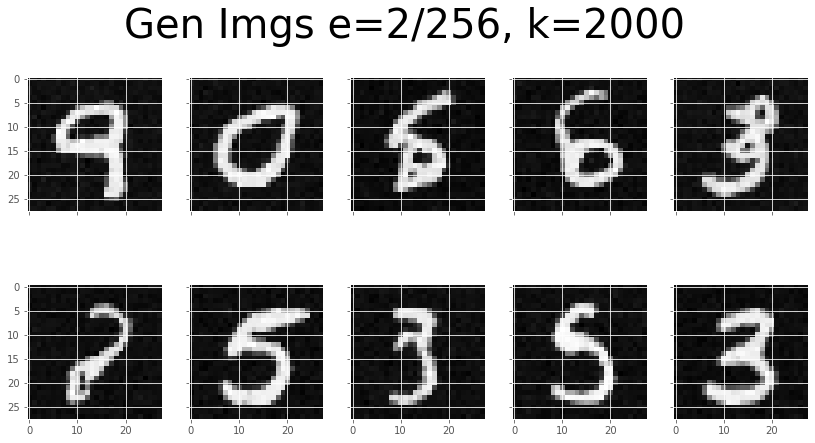

In [24]:
show_random_imgs(imgs=gen_imgs_e2_k20, title='Gen Imgs e=2/256, k=2000', width=5, height=2)

## $\color{#007FFF}{\textbf{Discussion:}}$
On the one hand the results look like real written digits because there is no noise and the contour is clear. Second, some of the generated digits can be easily identified. <br>
On the other hand some of the digits look like a combination of 2 or more digits such as 6&8, 3&6&9 and so on.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 6</span>**. Repeat the previous task for $K=2000$ iterations, this time with $\sqrt{2\varepsilon}=\frac{3}{256}$. Present the final samples and discuss the results comparing to the previous section.

In [25]:
imgs = torch.rand((n_imgs, 1, 28, 28), device=device)
imgs.requires_grad_(True)
gen_imgs_e3_k20 = mnist_langevin(imgs=imgs, K=2000, factored_epsilon=3/256)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:55<00:00, 35.74it/s]


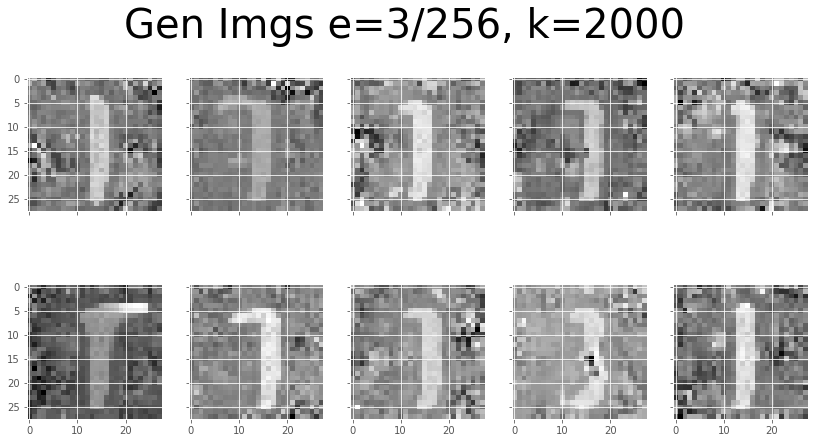

In [26]:
show_random_imgs(imgs=gen_imgs_e3_k20, title='Gen Imgs e=3/256, k=2000', width=5, height=2)

## $\color{#007FFF}{\textbf{Discussion:}}$
The results are very noisy and it seems like the model can only generate '1' digits. <br>
Clearly the step size isn't right.

## Part III: MALA (30 points) 

We will now expand Part II into the Metropolis-Adjusted Langevin Algorithm (MALA):

* Use the same initialization scheme as in Langevin Dynamics
* use the same update step as before
$$x^{k+1} = x^k + \varepsilon \nabla \log p(x^k) + \sqrt{2\varepsilon}N^k,$$
    with $\sqrt{2\varepsilon}=\frac{2}{256}$ and $N \sim \mathcal{N}(0,I)$.
* **Acceptance step**: accept the sample $x^{k+1}$ according to the acceptance rule:
    * If $x^{k+1}$ is more probable than $x^k$ then accept $x^{k+1}$
    * else, replace $x^{k+1}$ with $x^k$ with probability $\alpha$, where
    $$\alpha \triangleq \frac{p(x^{k + 1}) q(x^k \mid x^{k+1})}{p(x^k) q(x^{k+1}\mid x^k)}$$
    and
    $$q(x'\mid x) \propto \exp \left( - \frac{1}{4 \varepsilon} \| x' - x - \varepsilon \nabla \log p(x) \|_2^2 \right).$$

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 7</span>**. In the acceptance step of the MALA algorithm we can use $E(x)$ without explicitly knowing $p(x)$. Why?


#### $\color{#007FFF}{\textbf{Answer:}}$

Since the normalization factor is not affected by $x$ only by $\theta$ the effect of $Z(\theta)$ is neutrlized:
$$ \frac{P(x_{k+1})}{P(x_{k})} = \frac{\frac{1}{Z(\theta)}\cdot e^{-E_{\theta}(x_{k+1})}}{\frac{1}{Z(\theta)}\cdot e^{-E_{\theta}(x_k)}} = e^{ {-E_{\theta} (x_{k+1})} + {E_{\theta} (x_{k})} } $$
Therfore the question of $ P(x_{k+1}) > P(x_{k}) $  is equal to the question:
$$ {E_{\theta} (x_{k}) } > {E_{\theta} (x_{k+1})}  $$

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 8</span>**. Apply the MALA algorithm for $K=2000$ iterations. Present the final samples and discuss the results. 

In [27]:
def mnist_mala(imgs, K=2000, factored_epsilon = 2/256):
    epsilon = (factored_epsilon ** 2) / 2
    
    prev_energy = torch.tensor([1_000_000_000_000]).to(device)
    
    for k in tqdm.tqdm(range(K)):
        curr_energy = ebm(imgs) # 30x1x28x28
        curr_energy = curr_energy.sum()
        curr_grad = torch.autograd.grad(curr_energy, imgs)[0]
        
        if prev_energy > curr_energy:    
            noise = torch.randn(imgs.shape).to(device)
            imgs = imgs - epsilon * curr_grad + factored_epsilon * noise

        else:    
            alpha = get_alpha(curr_x = imgs, prev_x=prev_imgs, 
                              curr_x_energy_grad=curr_grad, prev_x_energy_grad=prev_grad, 
                              curr_x_energy=curr_energy, prev_x_energy=prev_energy, 
                              epsilon=epsilon)
            r = np.random.uniform()
            if r < alpha:
                noise = torch.randn(imgs.shape).to(device)
                imgs = imgs - epsilon * curr_grad + factored_epsilon * noise
            
        prev_energy = curr_energy
        prev_imgs = imgs.clone()
        prev_grad = curr_grad.clone()
    
    return imgs

#### $\color{#007FFF}{\textbf{Auxilliry Calculation:}}$

$$ \log\left(p_{\theta}(x)\right)=\log\left(\frac{1}{Z(\theta)}e^{-E_{\theta}(x)}\right)=-\log(Z(\theta))-E_{\theta}(x) $$

$$ \Rightarrow\nabla_{x}\log\left(p_{\theta}(x)\right)=-\nabla_{x}E_{\theta}(x) $$

$$ q(x'|x)\propto e^{-\frac{1}{4\epsilon}\|x'-x-\epsilon\nabla\log p(x)\|_{2}^{2}}=e^{-\frac{1}{4\epsilon}\|x'-x+\epsilon\nabla_{x}E_{\theta}(x)\|_{2}^{2}} $$

$$ \Rightarrow\frac{q(x^{k}|x^{k+1})}{q(x^{k+1}|x^{k})}=\frac{e^{-\frac{1}{4\epsilon}\|x^{k}-x^{k+1}+\epsilon\nabla_{x}E_{\theta}(x^{k+1})\|_{2}^{2}}}{e^{-\frac{1}{4\epsilon}\|x^{k+1}-x^{k}+\epsilon\nabla_{x}E_{\theta}(x^{k})\|_{2}^{2}}}=e^{-\frac{1}{4\epsilon}\left(\|x^{k}-x^{k+1}+\epsilon\nabla_{x}E_{\theta}(x^{k+1})\|_{2}^{2}-\|\|x^{k+1}-x^{k}+\epsilon\nabla_{x}E_{\theta}(x^{k})\|_{2}^{2}\|_{2}^{2}\right)} $$

In [28]:
def get_alpha(curr_x, prev_x, curr_x_energy_grad, prev_x_energy_grad, curr_x_energy, prev_x_energy, epsilon):
    p = get_p_ratio(curr_x_energy=curr_x_energy, prev_x_energy=prev_x_energy)
    q = get_q_ratio(curr_x=curr_x, prev_x=prev_x, curr_x_energy_grad=curr_x_energy_grad, 
                    prev_x_energy_grad=prev_x_energy_grad, epsilon=epsilon)
    return p * q

In [29]:
def get_p_ratio(curr_x_energy, prev_x_energy):
    return torch.exp(-curr_x_energy + prev_x_energy)

In [30]:
def get_q_ratio(curr_x, prev_x, curr_x_energy_grad, prev_x_energy_grad, epsilon):
    norma_1 = torch.norm(prev_x - curr_x + epsilon * curr_x_energy_grad) ** 2
    norma_2 = torch.norm(curr_x - prev_x + epsilon * prev_x_energy_grad) ** 2
    return torch.exp( -(1/(4*epsilon)) * (norma_1 - norma_2) )

In [31]:
imgs = torch.rand((n_imgs, 1, 28, 28), device=device)
imgs.requires_grad_(True)

gen_imgs_e2_k20_mala = mnist_mala(imgs, K=2000, factored_epsilon = 2/256)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.53it/s]


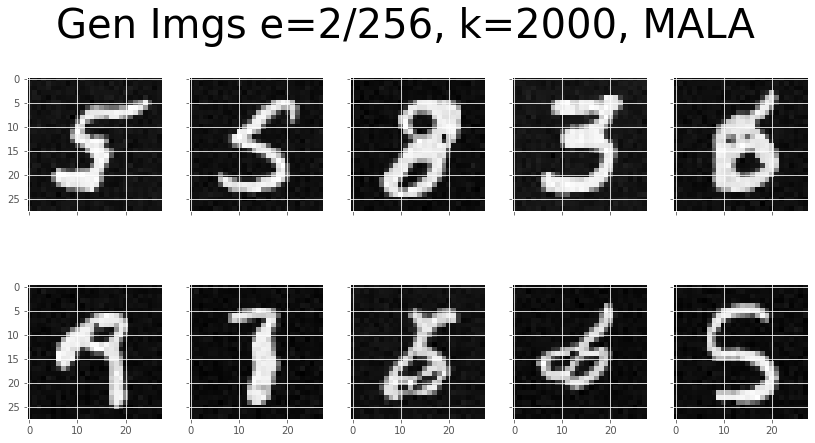

In [32]:
show_random_imgs(imgs=gen_imgs_e2_k20_mala, title='Gen Imgs e=2/256, k=2000, MALA', width=5, height=2)

## $\color{#007FFF}{\textbf{Discussion:}}$
Sucks

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 9</span>**. Apply the MALA algorithm for $K=2000$ iterations, with $\sqrt{2\varepsilon}=\frac{3}{256}$. Present the final samples and discuss the results.

In [33]:
imgs = torch.rand((n_imgs, 1, 28, 28), device=device)
imgs.requires_grad_(True)

gen_imgs_e3_k20_mala = mnist_mala(imgs, K=2000, factored_epsilon = 3/256)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.33it/s]


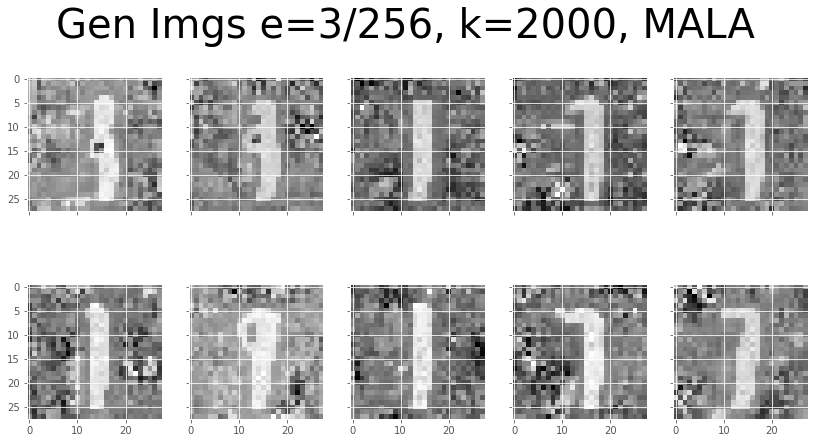

In [34]:
show_random_imgs(imgs=gen_imgs_e3_k20_mala, title='Gen Imgs e=3/256, k=2000, MALA', width=5, height=2)

## $\color{#007FFF}{\textbf{Discussion:}}$
Sucks

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 10</span>**. Apply the MALA algorithm for $K=20,000$ iterations (it might take a few minutes), with $\sqrt{2\varepsilon}=\frac{3}{256}$. **Instead of random initialization**, run Langevin dynamics as in Part II with $\sqrt{2\varepsilon}=\frac{2}{256}$ for $K=500$ iterations and use these images as your initialization for the MALA algorithm. Present the final samples and examples for samples in intermediate iterations. Discuss the results.

In [35]:
imgs = torch.rand((n_imgs, 1, 28, 28), device=device)
imgs.requires_grad_(True)
gen_imgs_e2_k5 = mnist_langevin(imgs=imgs, K=500, factored_epsilon=2/256)

gen_imgs_e3_k200_mala_init = mnist_mala(gen_imgs_e2_k5, K=20_000, factored_epsilon = 3/256)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [10:13<00:00, 32.58it/s]


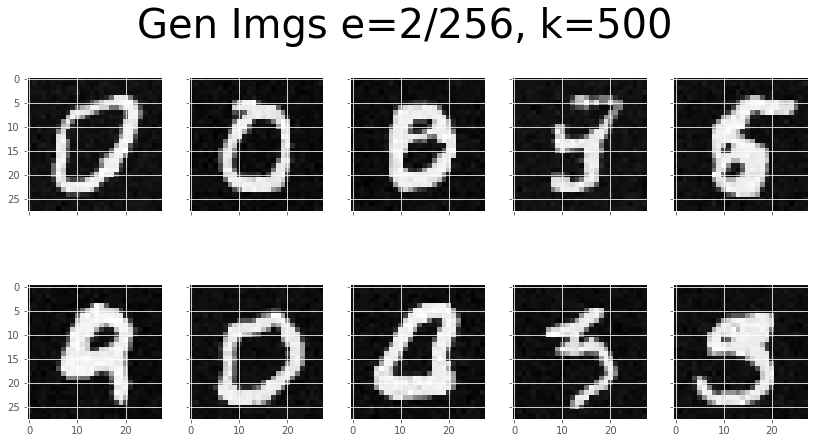

In [52]:
show_random_imgs(imgs=gen_imgs_e2_k5, title='Gen Imgs e=2/256, k=500', width=5, height=2)

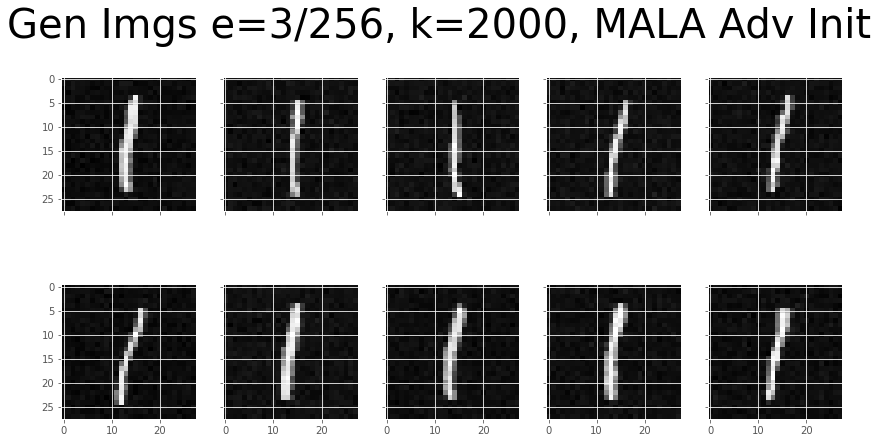

In [53]:
show_random_imgs(imgs=gen_imgs_e3_k200_mala_init, title='Gen Imgs e=3/256, k=2000, MALA Adv Init', width=5, height=2)

In [49]:
imgs = torch.rand((n_imgs, 1, 28, 28), device=device)
imgs.requires_grad_(True)
gen_imgs_e2_k5 = mnist_langevin(imgs=imgs, K=500, factored_epsilon=2/256)

gen_imgs_e3_k200_init = mnist_langevin(gen_imgs_e2_k5, K=20_000, factored_epsilon = 3/256)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:08<00:00, 40.94it/s]


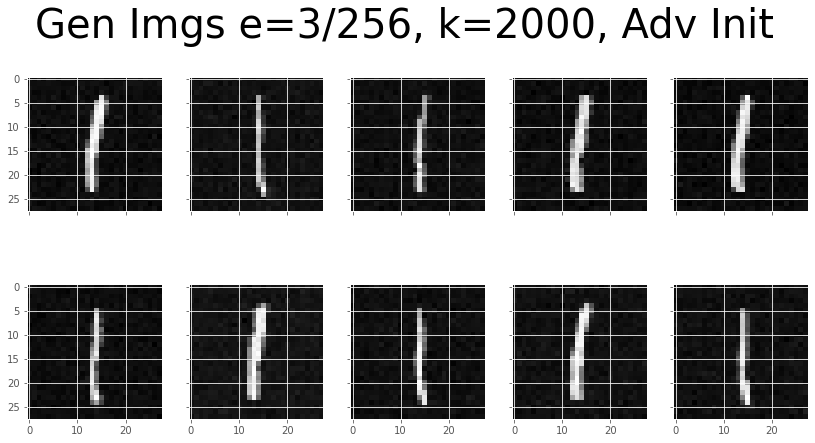

In [51]:
show_random_imgs(imgs=gen_imgs_e3_k200_init, title='Gen Imgs e=3/256, k=2000, Adv Init', width=5, height=2)

## $\color{#007FFF}{\textbf{Discussion:}}$
Sucks

## Part IV: Perceptual and MMSE Denoising (30 points) 

Given a noisy image $y = x + n$, where $x$ is a clean image and $n \sim \mathcal{N}(0, \sigma^2I)$, we would like to estimate $x$ using Langevin Dynamics and the EBM model trained to estimate $p(x)$. We will perform denoising by drawing samples from $p(x|y)$.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 11</span>**. Write an explicit expression for $\nabla_x\log p(x|y)$ in terms of $p_x(x)$ and $p_n(n)$.


#### $\color{#007FFF}{\textbf{Answer:}}$

$$ P(x|y)=\frac{1}{|2\pi \sigma^2 I|^{-1/2}}e^{-\frac{1}{2}\cdot(x-y)^{T}(\sigma^2I)^{-1}(x-y)} = \frac{1}{|2\pi\sigma^2|^{-d/2}}e^{-\frac{1}{2\sigma^2}\cdot\|x-y\|^2} $$
$$ \nabla_{x}\log P(x|y)=	\nabla_{x}\log(\frac{1}{|2\pi\sigma^2|^{-d/2}}e^{-\frac{1}{2\sigma^2}\cdot\|x-y\|^{2}})
=	\nabla_{x}\left(-\log(|2\pi\sigma^2|^{-d/2})-\frac{1}{2\sigma^2}\cdot\|x-y\|^{2}\right)
=	\frac{y-x}{\sigma^2} $$

$$ \nabla_{x}\log p(x|y)=	\nabla_{x}\log\left(\frac{1}{p(y)}p(y|x)p(x)\right) =$$ $$ \nabla_{x}\left(-\log (p(y))+\log (p(y|x))+\log (p(x))\right) =$$ $$
 \nabla_{x}\left(\log \left( p(y|x) \right)+\log \left(p(x)\right)\right) = $$ $$\nabla_{x}\left(\log \left( p_{n}(y-x) \right)+\log \left(p(x)\right)\right) = $$ $$ \nabla_{x}\log(\frac{1}{|2\pi\sigma^2|^{-d/2}}e^{-\frac{1}{2\sigma^2}\cdot\|y-x\|^{2}}) +\nabla_{x} log\left(p(x)\right) =$$ $$
\nabla_{x}\left(-\log(|2\pi\sigma^2|^{-d/2})-\frac{1}{2\sigma^2}\cdot\|y-x\|^{2}\right) + \nabla_{x} log\left(p(x)\right) 
=	\frac{y-x}{\sigma^2} + \nabla_{x} log\left(p(x)\right)  $$


<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 12</span>**. How should the update step in Langevin Dynamics (Part II) be changed in order to draw samples from $p(x|y)$ instead of $p(x)$? We call such samples *perceptual* denoising results.



#### $\color{#007FFF}{\textbf{Answer:}}$

Sucks

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 13</span>**. The attachment of this exercise includes 30 noisy digits with $\sigma=\left\{\frac{50}{256},\frac{100}{256}\right\}$ (you can load the images using the command `torch.load()`). Perform perceptual denoising with Langevin Dynamics with the parameters $K=2000$ and $\sqrt{2\varepsilon}=\frac{2}{256}$. Present and discuss the results.



In [37]:
noisy_digits_50 = torch.load('noisy_digits_50.pt').to(device).requires_grad_(True)
noisy_digits_100 = torch.load('noisy_digits_100.pt').to(device).requires_grad_(True)

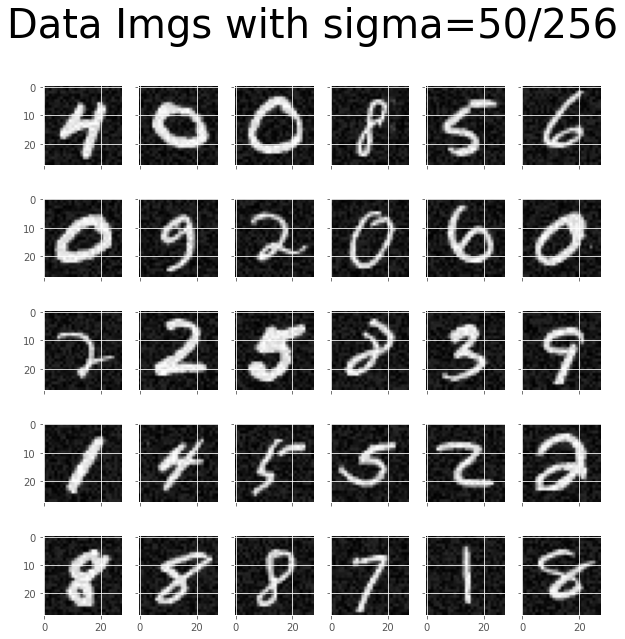

In [38]:
show_random_imgs(imgs=noisy_digits_50, title='Data Imgs with sigma=50/256', width=6, height=5, all_idx=True, figsize=(10,10))

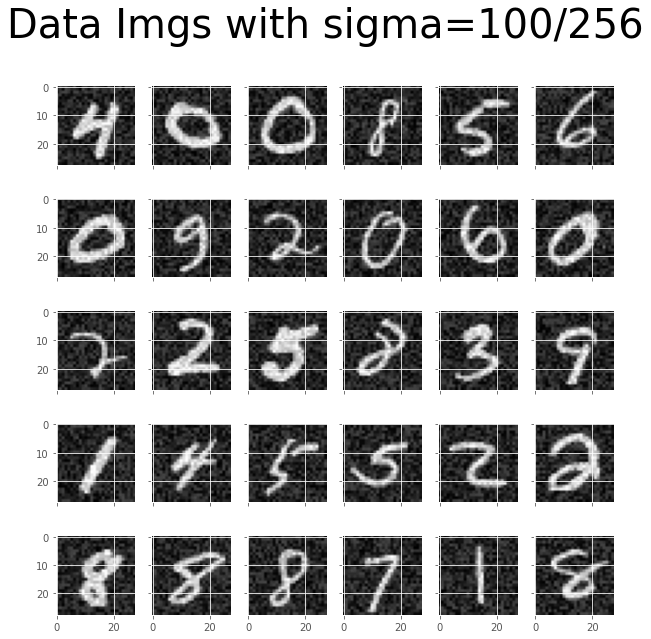

In [39]:
show_random_imgs(imgs=noisy_digits_100, title='Data Imgs with sigma=100/256', width=6, height=5, all_idx=True, figsize=(10,10))

In [59]:
def perceptual_denoising(imgs, K=2000, factored_epsilon = 2/256, sigma=50/256):
    x = torch.rand((n_imgs, 1, 28, 28), device=device).requires_grad_(True)
    y = torch.clone(imgs).to(device)
    energy = ebm(imgs)
    grad_ebm = -torch.autograd.grad(energy.sum(), imgs)[0]
    epsilon = (factored_epsilon ** 2) / 2
    for k in tqdm.tqdm(range(K)):

        grad = (y - x)/(sigma**2) + grad_ebm
        noise = torch.randn(imgs.shape).to(device)
        x = x + epsilon * grad + factored_epsilon * noise
        energy = ebm(x)
        grad_ebm = -torch.autograd.grad(energy.sum(), x)[0]
        
    return x

In [114]:
img_50_de = perceptual_denoising(imgs=noisy_digits_50, K=2000, factored_epsilon=2/256, sigma=(14/256))

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:06<00:00, 30.30it/s]


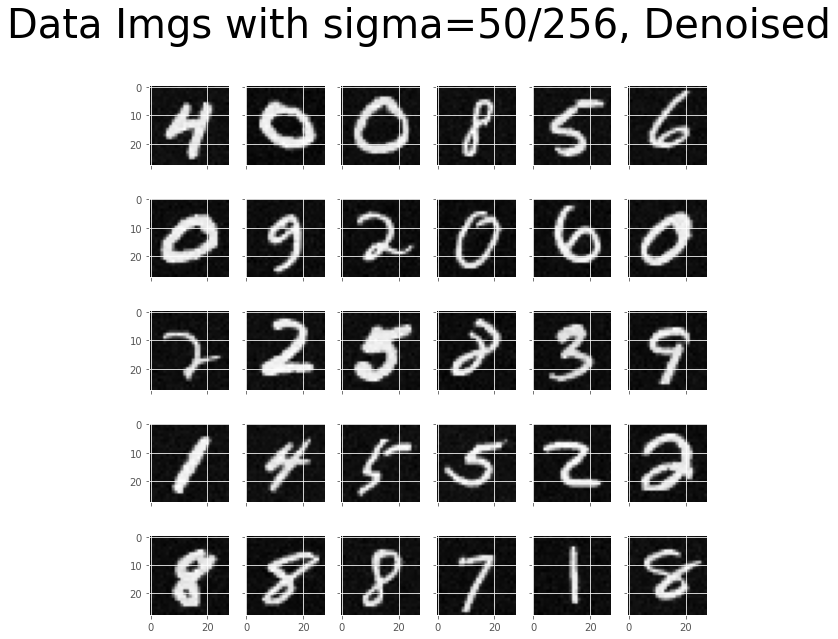

In [115]:
show_random_imgs(imgs=img_50_de, title='Data Imgs with sigma=50/256, Denoised', width=6, height=5, all_idx=True, figsize=(10,10))

In [116]:
img_100_de = perceptual_denoising(imgs=noisy_digits_100, K=2000, factored_epsilon=2/256, sigma=(28/256))

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.69it/s]


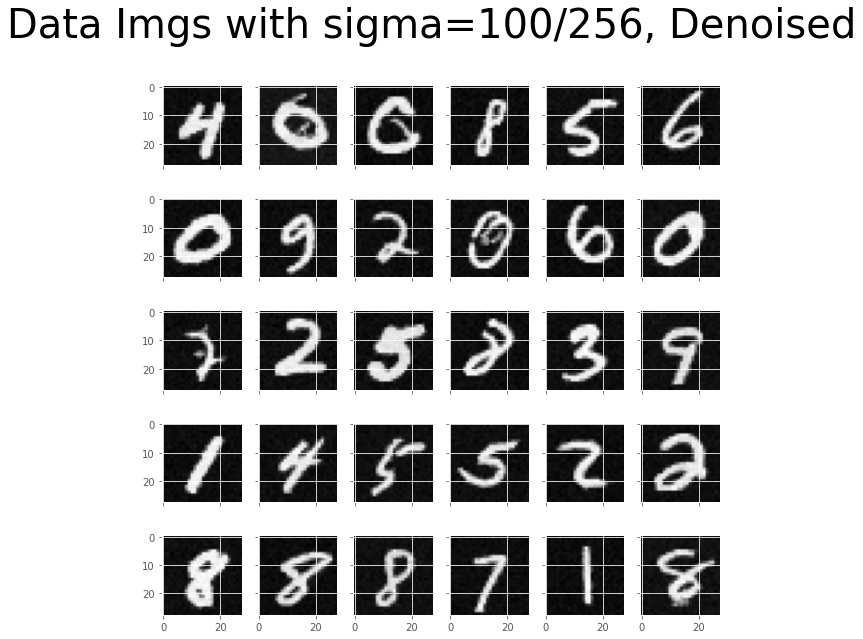

In [117]:
show_random_imgs(imgs=img_100_de, title='Data Imgs with sigma=100/256, Denoised', width=6, height=5, all_idx=True, figsize=(10,10))

In [89]:
l = []
for n in range(30):
    for i in range(6): 
        for j in range(6): 
            l.append((noisy_digits_100[n][0][27-i][27-j]).item())
np.array(l).std() * 256

28.392429319558723

In [113]:
for n in range(30):
    new_img = (noisy_digits_100[n][0] < 0.4) * noisy_digits_100[n][0]
    new_img = new_img[new_img != 0]
    print(to_np(new_img).std() * 256)

29.431377410888672
28.93292236328125
29.228322982788086
28.72871208190918
28.723262786865234
28.96641731262207
29.75530433654785
28.66948127746582
28.601728439331055
28.514110565185547
28.220897674560547
29.00701141357422
28.682558059692383
29.678634643554688
28.208391189575195
28.4013671875
29.21802520751953
29.295143127441406
28.8347110748291
29.674169540405273
28.7922306060791
29.42498016357422
29.028423309326172
29.098106384277344
28.4626522064209
28.172203063964844
28.98731803894043
28.40424346923828
28.92119789123535
30.318004608154297


## $\color{#007FFF}{\textbf{Discussion:}}$
Sucks

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 14</span>**. Minimum MSE denoising can be obtained by averaging over the perceptual denoising results, since the conditional expectation $E[x|y]$ can be approximated by averaging over samples from $p(x|y)$ (namely, $E[x|y] \approx \frac{1}{N}\sum_{n=1}^N x_n$, where $\{x_n\}$ are samples from $p(x|y)$). Present the MMSE results averages over 10 perceptual samples. Why do you think the task of *perceptual denoising* is called that way?

In [119]:
def mmse(imgs, N=10, K=2000, factored_epsilon=2/256, sigma=50/256):
    res = torch.zeros(imgs.shape).to(device)
    for n in range(N):
        res += perceptual_denoising(imgs, K=K, factored_epsilon = factored_epsilon, sigma=sigma)
    return res / N

In [121]:
clean = mmse(imgs=noisy_digits_100, K=2000, N=10, sigma=28/256)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:09<00:00, 28.74it/s]


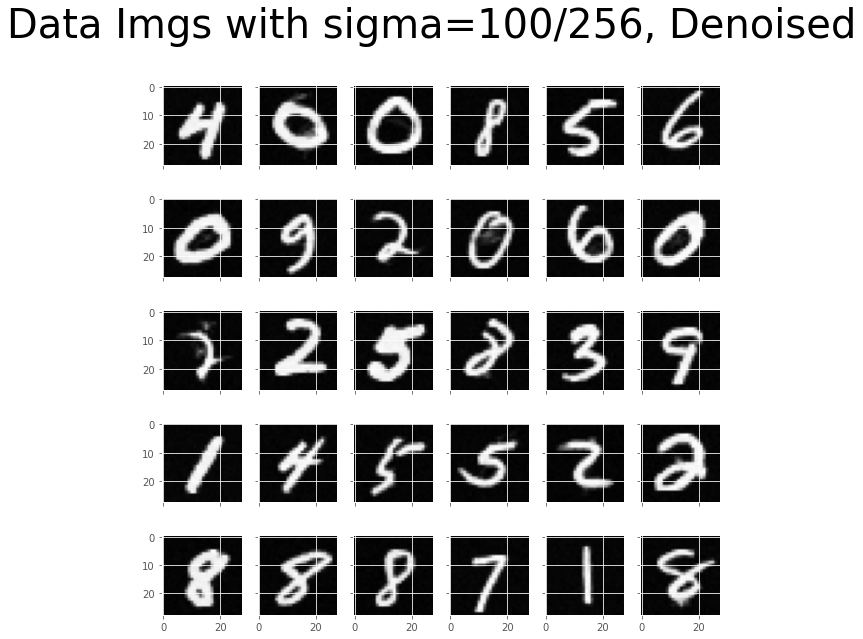

In [122]:
show_random_imgs(imgs=clean, title='Data Imgs with sigma=100/256, Denoised', width=6, height=5, figsize=(10,10), all_idx=True)

#### $\color{#007FFF}{\textbf{Answer:}}$

Sucks